# Geothermal Uplift Monitoring

## Background

You are continuing the task of monitoring the uplift caused by water injection at a specific site, building upon the initial data collection and analysis performed in the previous assignment.

### Data Focus: GNSS Observations
In the previous assignment, you collected and analyzed height data from two different techniques: Global Navigation Satellite Systems (GNSS) and Interferometric Synthetic-aperture radar (InSAR).
For this continuation assignment, we will focus exclusively on the GNSS height observations. This involves using the time series data provided in the file `gnss_observations.csv`, which lists observed vertical displacements (in meters). You will not be using the InSAR data in this week's assignment.

Stochastic Model of Observations
Consistent with the previous assignment, the GNSS observations are characterized by the following stochastic properties:
- They are normally distributed and independent.

- They have a known standard deviation $\sigma_\textrm{GNSS} = 15$ mm 

### Assignment Theme: Non-Linear Functional Models
The core focus of this week's work is the estimation of parameters using non-linear functional models. You will explore the techniques required to solve these models, including estimating the parameters and assessing the precision of the estimates, and conducting rigorous statistical evaluations using methods like the overall model test (OMT) and the generalized likelihood ratio test (GLRT).

In [44]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2
from scipy.stats import norm

np.set_printoptions(precision=3)

## Task 1: Preparing the data and code from last week's assignment

As mentioned, this assignment focuses on only the GNSS observations. Here the data is loaded. Make sure to add your own code where needed. You should have done this already in last week's assignment. You should add your BLUE function (`BLUE`) and your function for plotting the residuals (`plot_residuals`) from last week's assignment here.

In [45]:
gnss = pd.read_csv('./gnss_observations.csv')
gnss_dates = pd.to_datetime(gnss['Dates'])
gnss_doy = (gnss['Day of Year']).to_numpy()
gnss_obs = (gnss['Observations[m]']).to_numpy()

m_gnss = len(gnss_obs)
y_gnss = gnss_obs
std_gnss = 0.015 #m
Sigma_Y_gnss = np.identity(len(gnss_dates))*std_gnss**2

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>
Note: This code should be copied from your previous assigment.</div>

In [46]:
def BLUE(A, y, Sigma_Y):
    """Calculate the Best Linear Unbiased Estimator
    
    Write a docstring here (an explanation of your function).
    
    Function to calculate the Best Linear Unbiased Estimator
    
    Input:
        A = A matrix (mxn)
        y = vector with obervations (mx1)
        Sigma_Y = Varaiance covariance matrix of the observations (mxm)
    
    Output:
        xhat = vector with the estimates (nx1)
        Sigma_Xhat = variance-covariance matrix of the unknown parameters (nxn)
    """
    
    # YOUR_CODE_HERE
    
    Sigma_Xhat = np.linalg.inv(A.T @ np.linalg.inv(Sigma_Y) @ A)
    xhat = Sigma_Xhat @ A.T @ np.linalg.inv(Sigma_Y) @ y
    
    return xhat, Sigma_Xhat  

In [47]:
def plot_residual(date, y_obs, yhat, data_type, A,
                  Sigma_Xhat, Sigma_Y):

    ehat = y_obs - yhat

    # Compute the vc matrix for \hat{y}
    Sigma_Yhat = A @ Sigma_Xhat @ A.T
    std_y = np.sqrt(Sigma_Yhat.diagonal())

    # Compute the vc matrix for \hat{e}
    Sigma_ehat = Sigma_Y - Sigma_Yhat
    std_ehat = np.sqrt(Sigma_ehat.diagonal())
    
    # Compute residuals normalized by standard deviation
    ehat_normalized = ehat / std_ehat

    # Show the 99% confidence interval
    k99 = norm.ppf(1 - 0.5*0.01)
    confidence_interval_y = k99*std_y
    confidence_interval_res = k99*std_ehat

    # Plot original data and fitted model
    plt.figure(figsize = (15,5))
    plt.plot(date, y_obs, 'k+',  label = 'Observations')
    plt.plot(date, yhat,  label = 'Fitted model')
    plt.fill_between(date, (yhat - confidence_interval_y), 
                     (yhat + confidence_interval_y), facecolor='orange',
                     alpha=0.4, label = '99% Confidence Region')
    plt.legend()
    plt.ylabel(data_type + ' Displacement [mm]')
    plt.xlabel('Time')
    plt.title(data_type + ' Observations and Fitted Model')


    # Plot time series of the residual
    plt.figure(figsize = (15,5))
    plt.plot(date, ehat, 'o', markeredgecolor='black', label='Residual')
    plt.plot(date,-confidence_interval_res, '--', color='orange', 
             label = '99% Confidence Region')
    plt.plot(date,confidence_interval_res, '--', color='orange')
    plt.legend()
    plt.ylabel(data_type + ' residual [mm]')
    plt.xlabel('Time')
    plt.title(data_type + ' Residuals')

    # Plot histogram and normal distribution
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.hist(ehat_normalized, bins = 40, density=True,  edgecolor='black')
    x = np.linspace(np.min(ehat_normalized), np.max(ehat_normalized), num=100);
    plt.plot(x, norm.pdf(x, loc=0.0, scale = 1),
             linewidth=4.0)
    plt.title(data_type + ' Normalized Residuals Histogram')
    plt.xlabel('residual [mm]')
    plt.ylabel('density')
    
    # Q-Q plot
    plt.subplot(122)
    sc.stats.probplot(ehat_normalized, dist="norm", plot=plt)
    plt.title(data_type + ' Normalized Residuals Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles') 
    
    print (f'The mean value of the {data_type} residuals is {np.mean(ehat):.3f} m')
    print (f'The standard deviation of the {data_type} residuals is {np.std(ehat):.3f} m')

    return ehat

## 2. Set-up non-linear functional model

In the model we fitted so far, we only considered a linear velocity and seasonal variation in grounwater level. However, in reality the response to groundwater injection is likely to be more complicated than just a linear uplift. Therefore you will now consider a slightly more sophisticated, non-linear model to account for the observed uplift. 

*Please note that this is very simplified model that does not necessarily rely on physics.* 

The model under null hypothesis $H_0$ is defined as
$$
d = d_0 + v \ (1-\exp\left(\frac{-t}{a}\right)) + A\sin(\frac{2\pi t}{365} - \phi),
$$
where $d$ is the displacement, and $t$ is the time, and $\phi =\frac{\pi}{2}$. 

The model now has 4 unknowns:
1. $d_0$, the initial displacement at $t_0$
2. $v$, which can be seen as the response of the soil layers due to groundwater injection. 
3. $a$, a scaling parameter which represents the memory of the system
4. $A$, amplitude of the seasonal effect

It can be seen that the model is non-linear. We will therefore use non-linear least-squares to solve for the unknown parameters. 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1: </b>   
    
Choose initial values for the model parameters. Use the code and Markdown cells below to justify your decision. We suggest two possible approaches: a) use the forward model and make a plot to see if you can get it in the right order of magnitude, or b) make an inference about what the values might be using knowledge about each term in the model.
    
<i>Note: it may be useful at this point to define a function for your forward model to check the values. You will be able to re-use it in later Tasks as well.<i>
    
</p>
</div>

In [48]:
def forward_model(time, d_i, v_i, a_i, A_i):
    """Compute the displacements based on our initial guess.
    """

    y_comp = d_i + v_i*(1-np.exp(-time/a_i)) + A_i * np.sin(2 * np.pi * time / 365 - np.pi/2)

    return y_comp

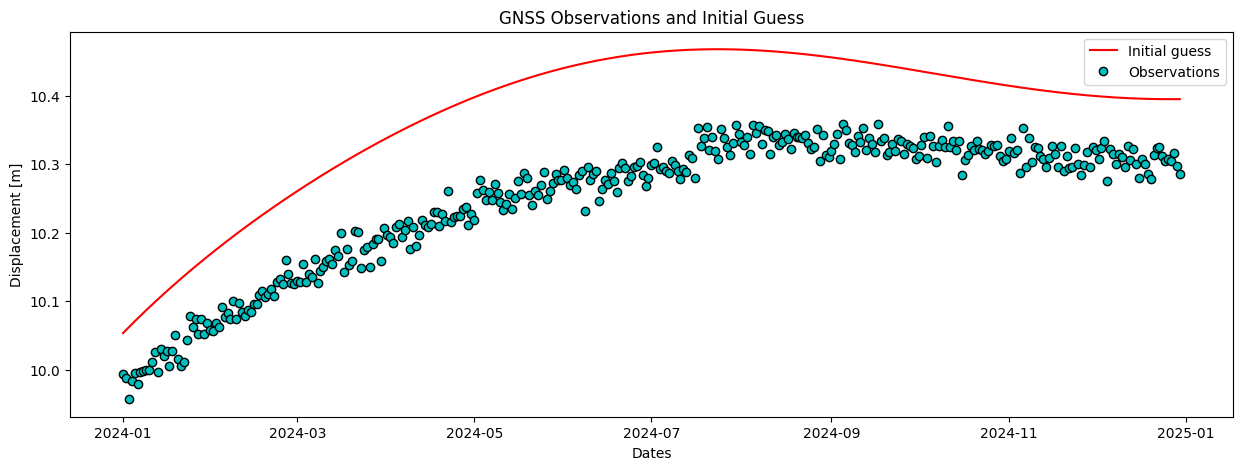

In [49]:

v_i = 0.35
a_i = 80
do_i = 10.099
A_i = 0.05

y_init = forward_model(gnss_doy, do_i, v_i, a_i, A_i)
plt.figure(figsize=(15,5))
plt.plot(gnss_dates, y_init, 'r-', label='Initial guess')
plt.plot(gnss_dates, gnss_obs, 'co', mec='black', label='Observations')
plt.title('GNSS Observations and Initial Guess')
plt.xlabel('Dates')
plt.ylabel('Displacement [m]')
plt.legend()
plt.show()

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

- For $d_0$ and $A$ you could use the estimated values from the linear model, but they do not work very well because their estimators are biased with the linear model.
    
- For $v$: realize that it is the difference between displacement at start and end of the observation interval (look at plot with data).
    
- For $a$: you could plot the curve with initial values and try different values of $a$ to see which one would fit the observations well here.
    


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2: </b>   
    
Set up the Jacobian matrix for the non-linear least-squares. Using the initial values from Task 8.1, print the first 5 rows of the Jacobian matrix to confirm that your function works (i.e., confirm code runs, and initial values give acceptable results).
    

</p>
</div>

In [50]:
def jacobian(time, do_i, R_i, a_i, A_i):
    """Create the Jacobian matrix.
    
    The columns represent the linearized system of equations.
    """    
    
    # J_c1 = 
    # J_c2 = 
    # J_c3 = 
    # J_c4 = 
    
    # SOLUTION
    J_c1 = np.ones(len(time))
    J_c2 = 1 - np.exp(-time/a_i)
    J_c3 = -R_i*time/a_i**2 * np.exp(-time/a_i)
    J_c4 = np.sin(2 * np.pi * time / 365 - np.pi/2)

    J = np.column_stack((J_c1, J_c2, J_c3, J_c4))
    
    return J

In [51]:
J = jacobian(gnss_doy, do_i, v_i, a_i, A_i)

print ('The first 5 rows of the Jacobian matrix are:')
print (J[0:5,:])

n_2 = np.shape(J)[1]
print(f'\nThe number of unknowns is {n_2}')
print(f'The redundancy (GNSS) is {m_gnss - n_2}')

The first 5 rows of the Jacobian matrix are:
[[ 1.000e+00  1.242e-02 -5.401e-05 -9.999e-01]
 [ 1.000e+00  2.469e-02 -1.067e-04 -9.994e-01]
 [ 1.000e+00  3.681e-02 -1.580e-04 -9.987e-01]
 [ 1.000e+00  4.877e-02 -2.081e-04 -9.976e-01]
 [ 1.000e+00  6.059e-02 -2.569e-04 -9.963e-01]]

The number of unknowns is 4
The redundancy (GNSS) is 361


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.3:</b>   
    
What is the redundancy of the model with GNSS?
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

- The number of unknowns is 4
- The redundancy (GNSS) is 361
    


## 3. Set-up Gauss-Newton iteration algorithm



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3: </b>   
    
Set up a Gauss-Newton iteration algorithm (complete the code below). Choose the criterion to stop the iteration. 
Explain below how and why you define the stop-criterium. 

</p>
</div>

In [52]:
def nlsq_iteration(x0, day, y_obs, Sigma_Y):
    """Use Gauss-Newton iteration to find non-linear parameters."""

    xnrm = 1000 # initialize stop criteria

    xhat_i = np.zeros((50, 4))
    xhat_i[0,:] = x0

    do_i = xhat_i[0,0]
    v_i = xhat_i[0,1]
    a_i = xhat_i[0,2]
    A_i = xhat_i[0,3]   

    iter_ind = 0

    while xnrm >= 1e-12 and iter_ind < 49:

        # computed deformation yi based on 'estimates' 
        y_i = forward_model(day, do_i, v_i, a_i, A_i)
        
        # dy = YOUR_CODE_HERE
        # SOLTUION
        dy = y_obs- y_i

                # J = YOUR_CODE_HERE
                # SOLTUION
        J = jacobian(day, do_i, v_i, a_i, A_i)


        # d_xhat, Sigma_Xhat = YOUR_CODE_HERE
        # Hint: re-use your function BLUE, above
        # SOLUTION
        d_xhat, Sigma_Xhat = BLUE(J, dy, Sigma_Y)


        xhat_i[iter_ind+1,:] = xhat_i[iter_ind,:] + d_xhat.T

        do_i  = xhat_i[iter_ind+1,0]
        v_i  = xhat_i[iter_ind+1,1]
        a_i  = xhat_i[iter_ind+1,2]
        A_i  = xhat_i[iter_ind+1,3]
        

        # xnrm = YOUR_CODE_HERE
        # SOLUTION
        xnrm = d_xhat.T @ np.linalg.inv(Sigma_Xhat) @ d_xhat

        # Update the iteration number
        iter_ind += 1

        if iter_ind==49:
            print("Number of iterations too large, check initial values.")

    xhat = xhat_i[iter_ind,:]
    xhat_i = xhat_i[0:iter_ind+1, :]
    return xhat, Sigma_Xhat, xhat_i, iter_ind, J


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>

We will use the 'weighted squared norm' of $\Delta \hat{\mathrm{x}}_{[i]}$, with the inverse covariance matrix $\Sigma_{\hat{X}}^{-1}$ as the weight matrix. In this way we account for different precisions of the parameters (high precision means we want the deviation to be smaller), as well as different order of magnitudes of the parameters.
    
</div>

## 4. Apply Gauss-Newton iteration



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.1: </b>   

Apply Gauss–Newton iteration on your model (run the code you completed above).
For each unknown parameter, plot your estimates versus the iteration number (horizontal axis: iteration number, vertical axis: parameter estimate).

Choose an appropriate number of iterations to clearly demonstrate the convergence behavior of your estimates.

</p>
</div>

In [53]:
x0 = [do_i, v_i, a_i, A_i]

[xhat_gnss, Sigma_Xhat_gnss, xhat_i_gnss, niter_gnss, J_final_gnss] = nlsq_iteration(x0, gnss_doy, y_gnss, Sigma_Y_gnss)

print('\n GNSS Reults for each iteration (#Interations =', niter_gnss, ')')
print(xhat_i_gnss)


 GNSS Reults for each iteration (#Interations = 7 )
[[1.010e+01 3.500e-01 8.000e+01 5.000e-02]
 [1.001e+01 3.416e-01 1.106e+02 2.415e-02]
 [1.001e+01 3.528e-01 1.260e+02 2.778e-02]
 [1.001e+01 3.548e-01 1.277e+02 2.802e-02]
 [1.001e+01 3.548e-01 1.276e+02 2.801e-02]
 [1.001e+01 3.548e-01 1.276e+02 2.801e-02]
 [1.001e+01 3.548e-01 1.276e+02 2.801e-02]
 [1.001e+01 3.548e-01 1.276e+02 2.801e-02]]


In [54]:

def plot_fit_iteration(xhat_i):
    """Plot value of each parameter, each iteration."""
    plt.figure(figsize = (18,9))

    plt.subplot(221)
    plt.plot(xhat_i[:,0], linewidth=4)
    plt.title('Estimated offset')
    plt.ylabel('Offset [m]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(222)
    plt.plot(xhat_i[:,1], linewidth=4)
    plt.title('Estimated v value')
    plt.ylabel('Estimated v value [m/year]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(223)
    plt.plot(xhat_i[:,2], linewidth=4)
    plt.title('Estimated $a$ value')
    plt.ylabel('a value [days]')
    plt.xlabel('Number of iterations [-]')

    plt.subplot(224)
    plt.plot(xhat_i[:,3], linewidth=4)
    plt.title('Estimated $A$ value')
    plt.ylabel('A value [m]')
    plt.xlabel('Number of iterations [-]')


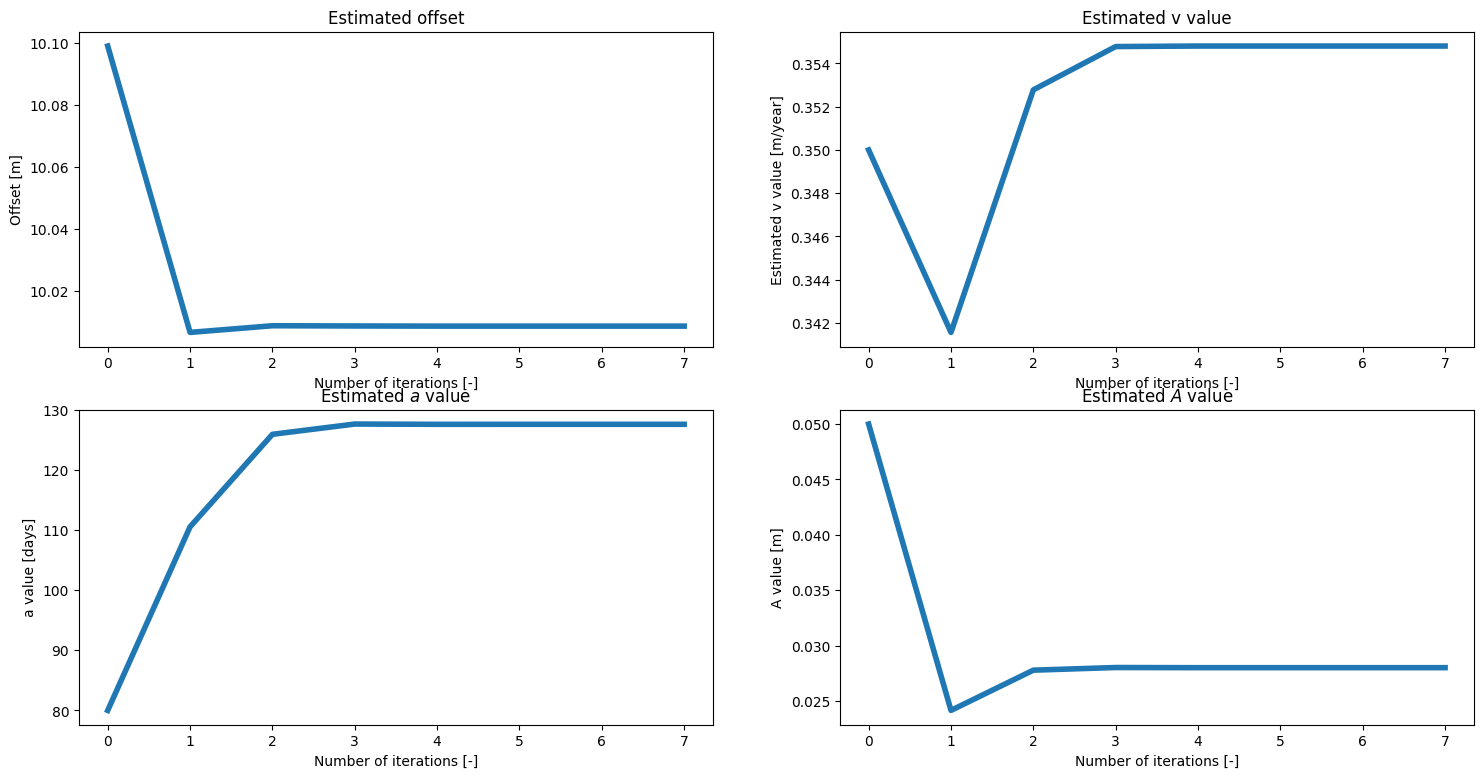

In [55]:
plot_fit_iteration(xhat_i_gnss)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4.2: </b>   
    
- Does your iteration converge? If not, find out why and provide an explanation.

- After how many iterations does it converge? 
    
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b>  

Convergence! 7 iterations.
    
</div>

## 5. Assess the precision of the estimates

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5: </b>     
    
What is the quality of the final estimates? 
    
Provide the full covariance matrix of your estimates, and give an interpretation of the numbers in the covariance matrix.
    
</p>
</div>

In [56]:
def show_std(Sigma_Xhat, data_type):
    print ('The standard deviation for',
           data_type + '-offset is',
           np.round(np.sqrt(Sigma_Xhat[0,0]),4), 'm')
    print ('The standard deviation for',
           data_type + '-velocity is',
           np.round(np.sqrt(Sigma_Xhat[1,1]),4), 'm/day')
    print ('The standard deviation for',
           data_type + '-a is',
           np.round(np.sqrt(Sigma_Xhat[2,2]),4), 'days')
    print ('The standard deviation for',
           data_type + '-amplitude is',
           np.round(np.sqrt(Sigma_Xhat[3,3]),4), 'm')

In [57]:
print ('\nCovariance matrix of estimated parameters (GNSS):')
print (Sigma_Xhat_gnss, '\n')
show_std(Sigma_Xhat_gnss, 'GNSS')


Covariance matrix of estimated parameters (GNSS):
[[ 2.892e-05 -8.648e-06  2.968e-02  8.673e-06]
 [-8.648e-06  1.057e-05 -2.049e-03 -1.701e-06]
 [ 2.968e-02 -2.049e-03  3.736e+01  9.939e-03]
 [ 8.673e-06 -1.701e-06  9.939e-03  4.005e-06]] 

The standard deviation for GNSS-offset is 0.0054 m
The standard deviation for GNSS-velocity is 0.0033 m/day
The standard deviation for GNSS-a is 6.1123 days
The standard deviation for GNSS-amplitude is 0.002 m


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

The quality of the estimated parameters is given by their Standard Deviations (Square roots of the diagonal elements of the covariance matrix) and the Covariances (off-diagonal elements). The off-diagonal elements (covariances) indicate correlation between the estimated parameters. A large covariance suggests the parameters are difficult to separate in the model.
</div>


## 6. Present the estimation results



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.1:</b>   
    
Compute the modeled displacements ($\hat{\mathrm{y}}$), and corresponsing residuals ($\hat{\mathrm{\epsilon}}$). 
Visualize the results in two graphs and add the confidence bounds ($t$-versus-displacement and $t$-versus-residuals).

Also create a histogram of the residuals where you plot the normal distribution (which you can estimate from the histogram) as well and report the mean and sigma of the residuals. 
</p>
</div>

The mean value of the GNSS residuals is 0.000 m
The standard deviation of the GNSS residuals is 0.016 m


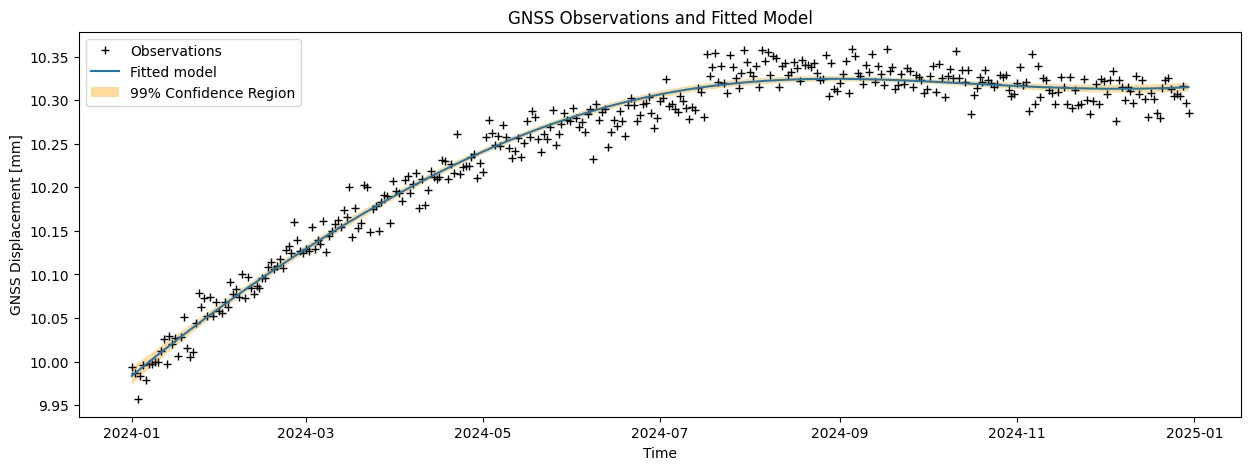

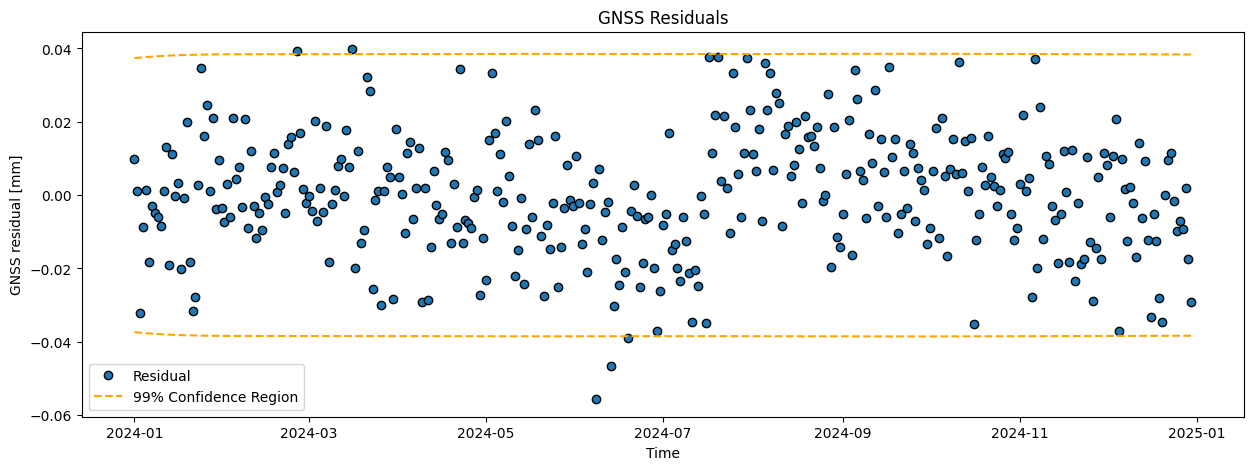

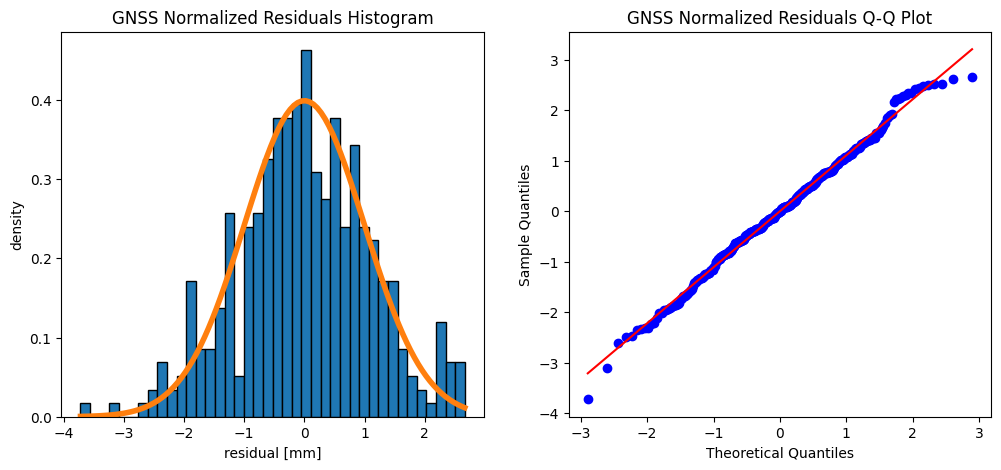

In [58]:
yhat_gnss_nonlinear = forward_model(gnss_doy, xhat_gnss[0], xhat_gnss[1], xhat_gnss[2], xhat_gnss[3])
ehat_gnss_nonlinear = plot_residual(gnss_dates, y_gnss, yhat_gnss_nonlinear,
                             'GNSS', J_final_gnss, Sigma_Xhat_gnss,
                             Sigma_Y_gnss)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6.2:</b>   

Answer the following questions:
<ol>
    <li>Do you see any systematic effect?</li>
    <li>Give your interpretation for any discrepancy between observations and the model?</li>
    <li>What is the mean value of the residuals and what does this value tells you?</li>
    <li>And what is the empirical standard deviation of the residuals? Is it as expected?</li>
</ol>
</p>
</div>




**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

    
The mean and standard deviations are as expected given the precision of 15 mm. However, a discontinuity can be observed in the residual plot around 2024-07, which may also explain the deviations in the upper tail of the residual distribution, as some residuals became larger than expected and the upper quantiles (outliers) no longer follow the expected distribution.

</div>

## 7. Detection
You would now like to test the validity of your model using the overall model test, with a false alarm probability of 95%. Is the null hypothesis (default model is correct) accepted?



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 7:</b>   

Conduct the Overall Model Test (OMT) to evaluate the statistical consistency of your non-linear model. Calculate the test statistic ($T_{\text{detection}}$) and determine the critical value ($T_{\text{critical}}$) at a 95% confidence level, using the model redundancy ($r$) as the degrees of freedom. Report the calculated test statistic and state wether you accept or reject the nullhypothesis ($H_0$).
</ol>
</p>
</div>

In [59]:
m,n = np.shape(J)
r = m - n

t_detection = ehat_gnss_nonlinear.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_nonlinear
T_detection = chi2.ppf(0.95, r)
print(f'\nTest statistic is {t_detection:.2f}, threshold is {T_detection:.2f}.') 
if t_detection < T_detection:
    print('We accept the null hypothesis H0')
else:
    print('We reject the null hypothesis H0')



Test statistic is 440.46, threshold is 406.30.
We reject the null hypothesis H0


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

    
Test statistic is 440.46, threshold is 406.30. We reject the null hypothesis H0
</div>

## 8 Model under $H_a$

As shown in the residual plot of the nonlinear model fitting, a shift may happen around 2024-07, which may explain the rejection of the null hypothesis. To test whether this is true and if so, to identifiy the epoch where the shift happens, you need to execute the Generalized Likelihood Ratio Test (GLRT). The following model under alternatives hypotheses $H_a$ needs to be considered, where the shift happens at $k$-th epoch, the observation equations under $H_a$ can be written as

$$
d = d_0 + v \ (1-\exp\left(\frac{-t}{a}\right)) + A\sin(\frac{2\pi t}{365} - \phi),\quad t<k \\
d = d_0 + v \ (1-\exp\left(\frac{-t}{a}\right)) + A\sin(\frac{2\pi t}{365}- \phi) + s,\quad t>=k,
$$
where $s$ is the size of the shift.

According to the observation equation under $H_a$, please update your functions to compute the forward model, Jacobian, and non-linear iteration.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8:</b>   

Implement the updated forward model and construct the new $5 \times 1$ Jacobian matrix $(\mathbf{J})$ required for this system. Then, set up the Gauss-Newton iteration algorithm to solve for the five non-linear parameters. 
</ol>
</p>
</div>

In [60]:
def forward_model_with_shift(time, do_i, v_i, a_i, A_i, k, shift):
    
    """Compute the displacements based on our initial guess.
    """
    
    y_comp = do_i + v_i*(1-np.exp(-time/a_i)) + A_i * np.sin(2 * np.pi * (time-90) / 365)
    y_shift = np.zeros(len(time))
    y_shift[time>=k] = shift
    y_comp = y_comp + y_shift
    
    return y_comp


def jacobian_with_shift(time, do_i, v_i, a_i, A_i, k, shift):
    
    """Create the Jacobian matrix.
    
    The columns represent the linearized system of equations.
    """    
    
    # SOLUTION
    J_c1 = np.ones(len(time))
    J_c2 = 1 - np.exp(-time/a_i)
    J_c3 = -v_i*time/a_i**2 * np.exp(-time/a_i)
    J_c4 = np.sin(2 * np.pi * (time-90) / 365)
    J_c5 = np.zeros(len(time))
    J_c5[time>=k] = 1

    J = np.column_stack((J_c1, J_c2, J_c3, J_c4, J_c5))

    return J


def nlsq_iteration_with_shift(x0, day, y_obs, Sigma_Y, k):
    """Use Gauss-Newton iteration to find non-linear parameters."""

    xnrm = 1000 # initialize stop criteria

    xhat_i = np.zeros((50, 5))
    xhat_i[0,:] = x0

    do_i = xhat_i[0,0]
    v_i = xhat_i[0,1]
    a_i = xhat_i[0,2]
    A_i = xhat_i[0,3]
    shift_i = xhat_i[0,4]

    iter_ind = 0

    while xnrm >= 1e-12 and iter_ind < 49:

        # computed deformation yi based on 'estimates' 
        y_i = forward_model_with_shift(day, do_i, v_i, a_i, A_i, k, shift_i)
        
        # dy = YOUR_CODE_HERE
        # SOLTUION
        dy = y_obs- y_i

        # J = YOUR_CODE_HERE
        # SOLTUION
        J = jacobian_with_shift(day, do_i, v_i, a_i, A_i, k, shift_i)


        # d_xhat, Sigma_Xhat = YOUR_CODE_HERE
        # Hint: re-use your function BLUE, above
        # SOLUTION
        d_xhat, Sigma_Xhat = BLUE(J, dy, Sigma_Y)


        xhat_i[iter_ind+1,:] = xhat_i[iter_ind,:] + d_xhat.T

        do_i  = xhat_i[iter_ind+1,0]
        v_i  = xhat_i[iter_ind+1,1]
        a_i  = xhat_i[iter_ind+1,2]
        A_i  = xhat_i[iter_ind+1,3]
        shift_i = xhat_i[iter_ind+1,4]

        # xnrm = YOUR_CODE_HERE
        # SOLUTION
        xnrm = d_xhat.T @ np.linalg.inv(Sigma_Xhat) @ d_xhat

        # Update the iteration number
        iter_ind += 1

        if iter_ind==49:
            print("Number of iterations too large, check initial values.")

    xhat = xhat_i[iter_ind,:]
    xhat_i = xhat_i[0:iter_ind+1, :]
    return xhat, Sigma_Xhat, xhat_i, iter_ind, J


## 9. Model identification with GLRT

You know that the shift happens at the days in the range $195$ to $204$, which means you have 10 alternative hypotheses with $195\leq k<=204$. Compute the test statistics of the GLRT for each alternative hypothesis. Then find the day of shift by identifying the most likely alternative hypothesis. 


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9.1:</b>   

Utilize the Generalized Likelihood Ratio Test (GLRT) to estimate the most likely day the shift occurred, knowing $k$ is between day 195 and 204. For each possible day $k$, run the Gauss-Newton algorithm and compute the GLRT test statistic, which measures the improvement over the no-shift model. Finally, identify the day $\mathbf{k}_{\text{hat}}$ corresponding to the maximum test statistic and report this estimated day of shift.
</ol>
</p>
</div>

In [62]:
x0 = [do_i, v_i, a_i, A_i, 0]

T_GLRT = np.zeros(10)
for k in range(195,205):
    [xhat_k, Sigma_Xhat_k, xhat_i_k, niter_k, J_final_k] = nlsq_iteration_with_shift(x0, gnss_doy, y_gnss, Sigma_Y_gnss, k)
    yhat_gnss_k = forward_model_with_shift(gnss_doy, xhat_k[0], xhat_k[1], xhat_k[2], xhat_k[3], k, xhat_k[4])
    ehat_gnss_k = y_gnss - yhat_gnss_k
    t_GLRT = t_detection - ehat_gnss_k.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_k
    T_GLRT[k-195] = t_GLRT
    
i_GLRT = np.argmax(T_GLRT)
k_hat = i_GLRT + 195
print('\nGLRT Test Statistics for each assumed change point k:')
print(T_GLRT)
print(f'\nThe estimated time of the shift is day {k_hat}, with test statistic {T_GLRT[i_GLRT]:.2f}.')



GLRT Test Statistics for each assumed change point k:
[ 82.529  89.922  89.933  91.489 102.7    90.648  87.206  80.782  70.194
  69.253]

The estimated time of the shift is day 199, with test statistic 102.70.


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

    
The estimated time of the shift is day 199, with test statistic 105.63.
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9.2:</b>   

Plot the fited model and the residuals of the selected alternative hypothesis. 

</ol>
</p>
</div>

The mean value of the GNSS residuals is 0.000 m
The standard deviation of the GNSS residuals is 0.014 m


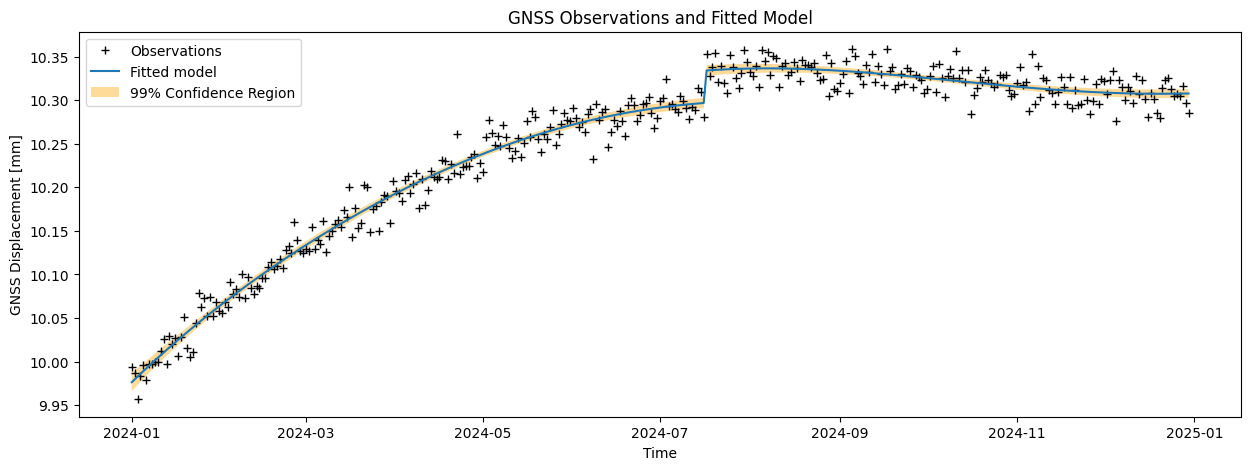

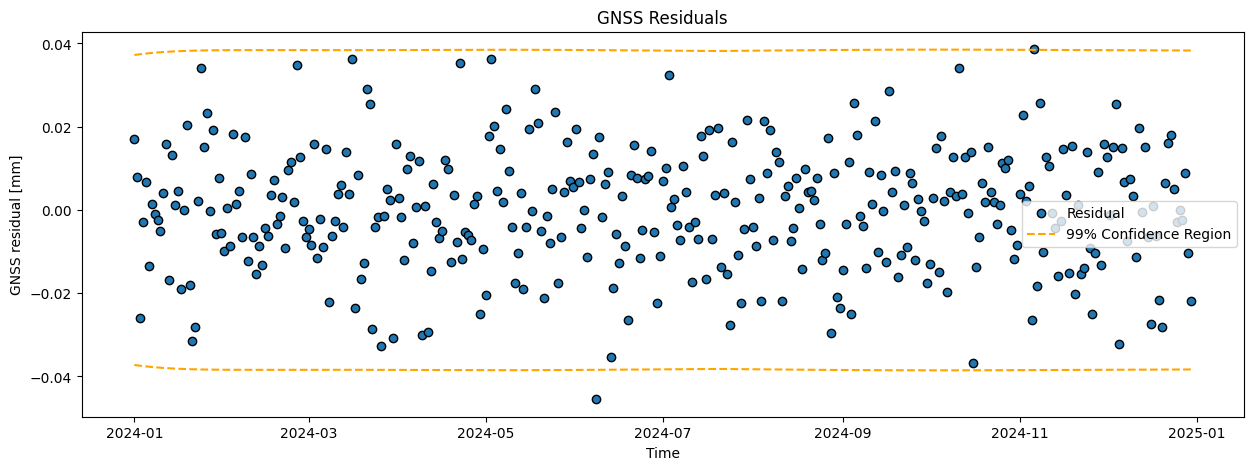

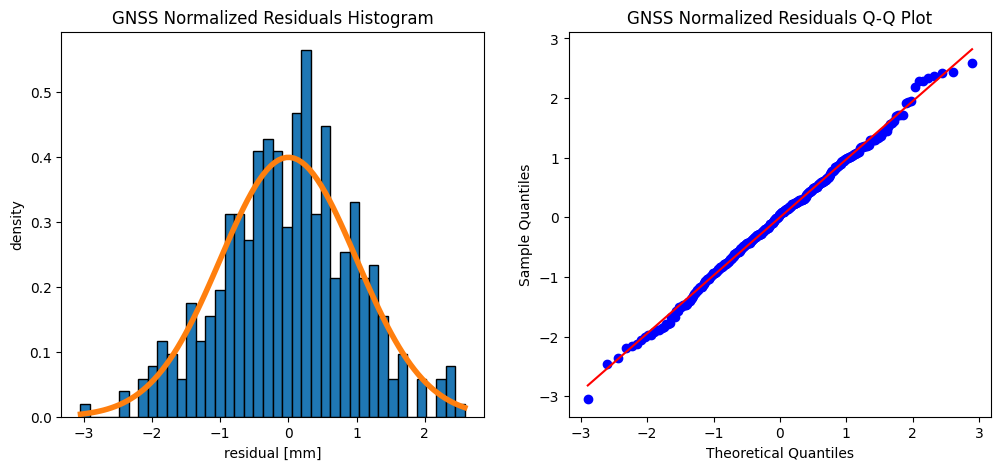

In [63]:
[xhat_k, Sigma_Xhat_k, xhat_i_k, niter_k, J_final_k] = nlsq_iteration_with_shift(x0, gnss_doy, y_gnss, Sigma_Y_gnss, k_hat)

yhat_gnss_k = forward_model_with_shift(gnss_doy, xhat_k[0], xhat_k[1], xhat_k[2], xhat_k[3], k=k_hat, shift=xhat_k[4])
ehat_gnss_k = plot_residual(gnss_dates, y_gnss, yhat_gnss_k,
                             'GNSS', J_final_k, Sigma_Xhat_k,
                             Sigma_Y_gnss)

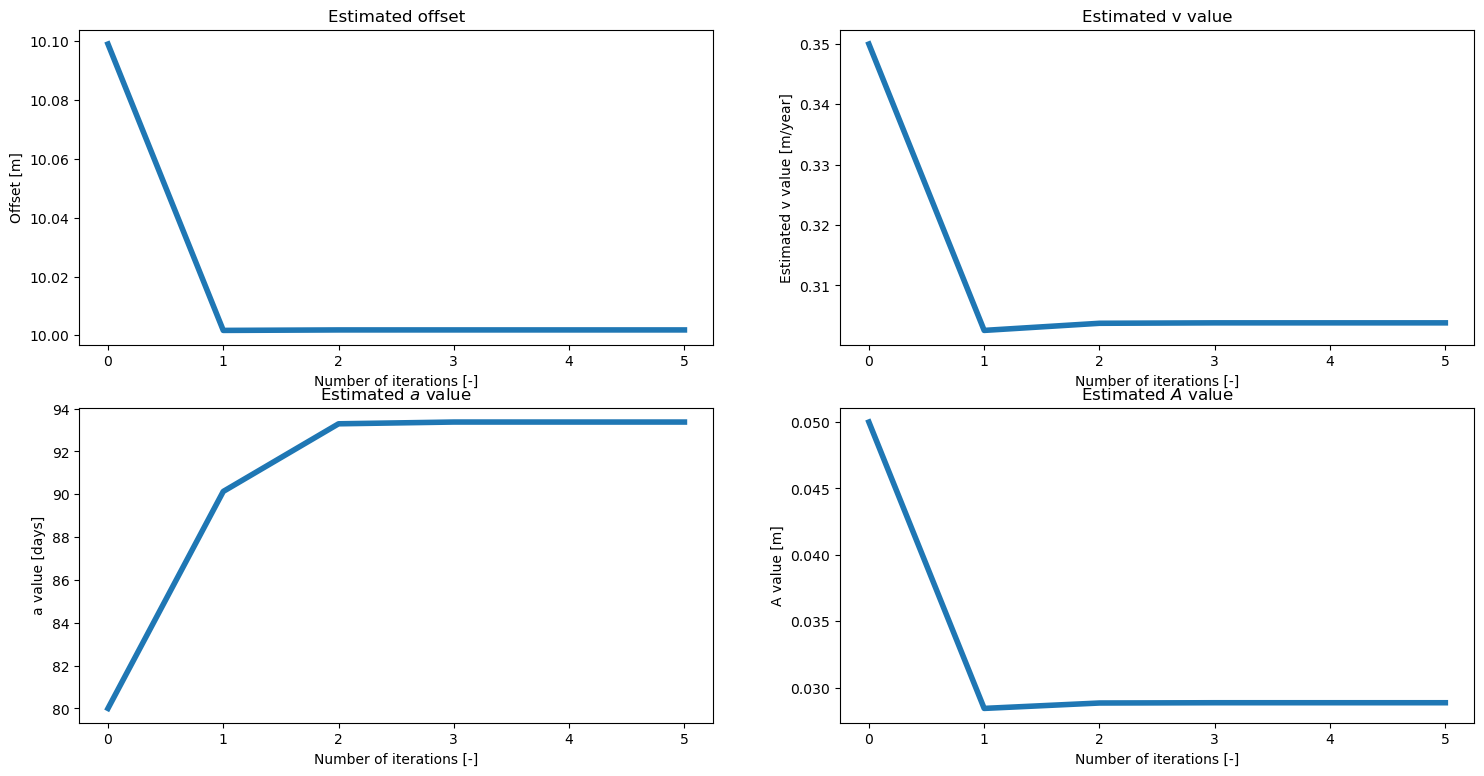

In [23]:
plot_fit_iteration(xhat_i_k)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9.3:</b>   

Rerun the Overall Model Test (OMT) using the parameters estimated with the optimal shift day, $\mathbf{k}_{\text{hat}}$, identified. Report the new test statistic value. Based on the comparison with the critical value, state whether you accept or reject the Null Hypothesis ($H_0$) and briefly explain what this result indicates about the final model's validity.

</ol>
</p>
</div>

In [64]:
m,n = np.shape(J_final_k)
r = m - n

t_detection = ehat_gnss_k.T @ np.linalg.inv(Sigma_Y_gnss) @ ehat_gnss_k
T_detection = chi2.ppf(0.95, r)
print(f'\nTest statistic is {t_detection:.2f}, threshold is {T_detection:.2f}.') 
if t_detection < T_detection:
    print('We accept the current model')
else:
    print('We reject the current model')


Test statistic is 337.76, threshold is 405.24.
We accept the current model


**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

Test statistic is 337.76, threshold is 405.24. We accept the current model
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9.4:</b>   

Compare the final, selected model (with shift $s$ at day $\mathbf{k}_{\text{hat}}$) against the initial model under $H_0$ (the model without shift) in terms of overall model fit and residual statistics. Explain in detail why it is essential to rely on the statistical tests (like the $\chi^2$ and GLRT) rather than solely on visual inspection, especially when the simpler $H_0$ model might appear "good enough" when simply plotted against the observations.
</ol>
</p>
</div>




**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 

- Less residuals are outside the confidence interval.
- Residual has smaller standard deviation, distribution fits normal distribution
- The value of the estimated $a$ changes from around 130 to 93, which shows how the mismodelling can affect the parameter estimation. This can be very important in case the model is used for predicting the displacements for the future!
</div>



## 17. Strategies to improve?


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 10:</b>   

In order to get a better fit to the data (smaller residuals) for this case study, which of the following strategies could help? (elaborate on your answer)
<ol>
    <li>better observations?</li>
    <li>a more complicated geophysical model?</li>
    <li>better initial values?</li>
    <li>more observations?</li>
</ol>
</p>
</div>

**Write your answer in this Markdown cell.**

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Solution:</b> 
<ol>
    <li>better observations will help, and should result in smaller residuals.</li>
    <li>a more complicated geophysical model will help if it is able to capture the signal. However, since we don't see any systematic effects in the InSAR residuals, it is not expected that much gain can be expected. Including more parameters in the model will help to get smaller residuals, but is there still a geophysical explanation...?</li>
    <li>better initial values won't help, since solution converged to valid results.</li>
    <li>more observations generally helps, as long as they are not corrupted by outliers or systematic effects.</li>
</ol> 
</div>

> By Chengy Yin, Lina Hagenah and Sandra Verhagen, Delft University of Technology. CC BY 4.0, more info on the Credits page of Workbook.